# Risk Parity Investment Strategy
## Use Index of representative asset classes
#### Developed-Emerging Equity, Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included
### Resuld is driven from 2010 to 2021 market data

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
import math
import numpy as np
import pandas as pd
import quantstats
from scipy.optimize import minimize

from utils.index_data import index_data

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

#### Load Data of each asset classes
#### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [6]:
data_setting = {
    'start' : '2002-01-01',
    'end' : '2021-10-30',
    'rebal_period':'1M'
}

data = index_data(**data_setting)
yield_df = data.index_data_loading()
yield_df

,msci_world,msci_emerging,msci_real_estate,snp_infra,bb_short_treasury,bb_long_maturity,bb_corp_ig,bb_corp_hy,bb_infla_protect,snp_metal,snp_oil
2002-01-31,0.016449,0.063876,0.022710,0.000774,-0.002436,-0.023532,-0.010831,-0.004277,-0.012717,0.050930,0.049673
2002-02-28,-0.035953,0.030178,-0.032724,-0.029901,0.006256,0.016165,0.013948,0.006756,0.008887,0.002242,-0.039237
2002-03-31,0.013737,0.029569,0.009666,0.039603,0.001255,0.001891,-0.000099,-0.014643,0.011282,0.026539,0.051396
2002-04-30,0.024798,0.040303,0.033943,0.129861,-0.004442,-0.022751,-0.013791,0.024335,-0.003210,0.107285,0.114534
2002-05-31,-0.029700,0.007080,0.058081,-0.019523,0.011479,0.029671,0.011728,0.015844,0.029441,-0.045188,0.014954
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,0.038195,0.002734,0.048829,0.075171,0.000970,0.007341,0.006059,0.010157,0.014751,0.053637,-0.030761
2021-06-30,0.011310,0.038808,0.026639,0.034986,0.000911,0.002301,0.004492,0.002682,0.010239,0.124030,0.143741
2021-07-31,0.015486,-0.016271,0.004921,0.034147,-0.001601,0.009949,0.017558,0.013973,0.005891,-0.091445,0.047279
2021-08-31,0.016152,-0.054896,0.039055,-0.007089,0.002209,0.025234,0.017403,0.002585,0.026053,0.018103,-0.180144


In [7]:
def RiskParity(covariance_matrix) :
    """
    to calculate r
    :param covariance_matrix: covariance matrix of assets in universe
    :return: [list] weight of risk parity investment strategy
    """
    x0 = np.repeat(1/covariance_matrix.shape[1], covariance_matrix.shape[1])
    constraints = ({'type': 'eq', 'fun': SumConstraint},
                  {'type': 'ineq', 'fun': LongOnly})
    options = {'ftol': 1e-20, 'maxiter': 2000}

    result = minimize(fun = RiskParityObjective,
                      args = (covariance_matrix),
                      x0 = x0,
                      method = 'SLSQP',
                      constraints = constraints,
                      options = options)
    return result.x

def RiskParityObjective(x, covariance_matrix) :
    # x means weight of portfolio
    variance = (x.T) @ (covariance_matrix) @ (x)
    sigma = np.sqrt(variance)
    mrc = 1/sigma * (covariance_matrix @ x)
    risk_contribution = x * mrc
    a = np.reshape(risk_contribution.to_numpy(), (len(risk_contribution), 1))

    # set marginal risk level of asset classes equal
    risk_diffs = a - a.T
    # np.ravel: convert n-dim to 1-dim
    sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
    return (sum_risk_diffs_squared)

# constraint 1 : sum of weight should be less than equal to 1
def SumConstraint(weight):
    return (weight.sum()-1.0)

# constraint 2 : long only portfolio should be consists of postive weight vectors
def LongOnly(weight):
    return(weight)

def RiskContribution(weight, covariance_matrix) :
    """
    to check whether given portfolio is equally distributed
    :param weight: asset allocation weight of portfolio
    :param covariance_matrix:
    :return: risk contribution of each asset
    """
    weight = np.array(weight)
    variance = np.dot(np.dot(weight.T, covariance_matrix) ,weight)
    sigma = np.sqrt(variance)
    mrc = 1/sigma * np.dot(covariance_matrix, weight)

    risk_contribution = weight * mrc
    risk_contribution = risk_contribution / risk_contribution.sum()
    return risk_contribution

# Risk parity strategy Result
## 12 month market data driven investment strategy
## from 2002 to 2021 follwoing asset classes (index) are used to backtest

#### use previous 12 month market data for risk parity portfolio calcuation
#### rebalance monthly (beginning of month)
#### developed equity, emerging equity, real estate, infrastructure, metal, oil
#### short term bond, long term bond, investment grade corp bond, high yield corp bond, TIPS

In [8]:
def monthly_rebalance_strategy(yld_df):
    # yld_df_12m = yld_df.resample('1M').first()
    yld_df_12m = yld_df
    yld_df_12m['RP_Weight'] = ""
    RP_Weight = []
    for i in range(len(yld_df_12m)):
        if i < 12:
            # since it
            RP_Weight.append('')
        else:
            covmat = pd.DataFrame(yld_df_12m.iloc[i-12 : i-1]).cov()

            RP_Weight.append(RiskParity(covariance_matrix = covmat).tolist())
            # yld_df_12m.loc[i,'RP_Weight']=RiskParity(covariance_matrix = covmat)

    yld_df_12m['RP_Weight'] = RP_Weight
    # rebalance portfolio every 12 month, thus first 12 month cannot make position
    yld_df_12m = yld_df_12m.iloc[12:,:]

    RP_Return = []
    ret = 0
    for i in range(yld_df_12m.shape[0]):
        # investment return of asset class * weight of asset class
        for j in range(yld_df_12m.shape[1]-1):
            ret += (yld_df_12m.iloc[i,j]) * ((yld_df_12m['RP_Weight'].iloc[i])[j])

        RP_Return.append(ret)
        ret = 0

    yld_df_12m['RP_Return'] = RP_Return
    yld_df_12m

    return yld_df_12m

In [9]:
month_rebal_strategy = monthly_rebalance_strategy(yield_df)
month_rebal_strategy

,msci_world,msci_emerging,msci_real_estate,snp_infra,bb_short_treasury,bb_long_maturity,bb_corp_ig,bb_corp_hy,bb_infla_protect,snp_metal,snp_oil,RP_Weight,RP_Return
2003-01-31,-0.047550,-0.040142,-0.029980,0.098477,0.007911,0.019927,0.019065,0.013679,0.024101,0.014006,0.051911,"[0.027887664802192163, 0.02633273967994195, 0....",0.010819
2003-02-28,-0.022292,-0.001061,-0.022009,0.055763,0.004179,0.005718,0.014489,0.033187,0.015886,-0.097094,-0.042768,"[0.02553438638445803, 0.02000693606667693, 0.0...",0.004023
2003-03-31,-0.028197,-0.024770,0.003232,0.099802,0.005774,0.025155,0.022277,0.012647,0.038594,-0.060943,0.025484,"[0.03141280763570959, 0.023215220864348893, 0....",0.010909
2003-04-30,0.005221,-0.038643,-0.044744,-0.139184,0.001850,-0.007185,-0.001280,0.030030,-0.015867,-0.052125,0.014839,"[0.03149222550132872, 0.023562150540639402, 0....",-0.007134
2003-05-31,0.077064,0.079040,0.031102,-0.039819,0.004074,0.002962,0.020383,0.056979,-0.000778,0.091646,-0.007563,"[0.029635192917078668, 0.022369970137407512, 0...",0.010395
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,0.038195,0.002734,0.048829,0.075171,0.000970,0.007341,0.006059,0.010157,0.014751,0.053637,-0.030761,"[0.016988463757891623, 0.023477225172197393, 0...",0.008939
2021-06-30,0.011310,0.038808,0.026639,0.034986,0.000911,0.002301,0.004492,0.002682,0.010239,0.124030,0.143741,"[0.015015054014878628, 0.0184222364568273, 0.0...",0.006728
2021-07-31,0.015486,-0.016271,0.004921,0.034147,-0.001601,0.009949,0.017558,0.013973,0.005891,-0.091445,0.047279,"[0.011631158555156161, 0.01258102801848281, 0....",0.001112
2021-08-31,0.016152,-0.054896,0.039055,-0.007089,0.002209,0.025234,0.017403,0.002585,0.026053,0.018103,-0.180144,"[0.01184375525956984, 0.01261704751866744, 0.0...",0.004979


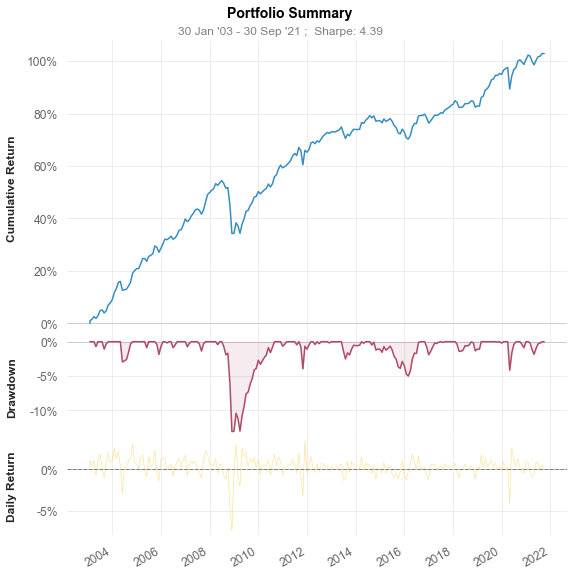

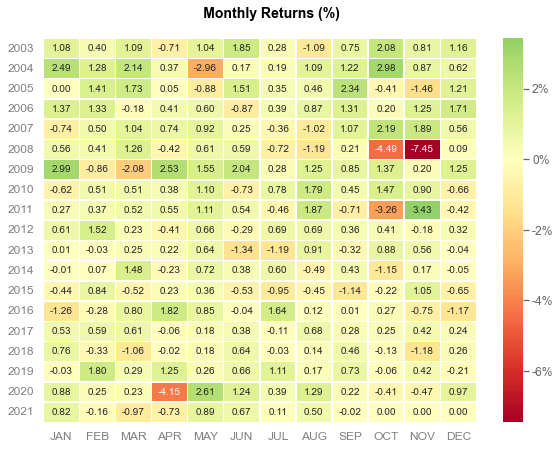

In [10]:
quantstats.reports.plots(month_rebal_strategy['RP_Return'], mode='basic')

In [11]:
quantstats.reports.metrics(month_rebal_strategy['RP_Return'], mode='full')


                           Strategy
-------------------------  ----------
Start Period               2003-01-31
End Period                 2021-09-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          102.83%
CAGR﹪                     3.86%

Sharpe                     4.4
Smart Sharpe               3.82
Sortino                    6.34
Smart Sortino              5.51
Sortino/√2                 4.48
Smart Sortino/√2           3.9
Omega                      2.23

Max Drawdown               -13.1%
Longest DD Days            761
Volatility (ann.)          18.44%
Calmar                     0.29
Skew                       -1.85
Kurtosis                   10.53

Expected Daily %           0.31%
Expected Monthly %         0.31%
Expected Yearly %          3.79%
Kelly Criterion            38.19%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.59%
Expected Shortfall (cVaR)  -1.59%

Gain/Pain Ratio            1.23
Gain/Pain (1M)             1